**File: LEOKA_train_multilabel.ipynb**\
Author: Amber Converse\
Purpose: This file trains 2 multi-label classification models on labeled stories from LEOKA using BERT base and ConfliBERT English.

Both models use the same architecture as BERT base, but on a model pre-trained on texts related political conflict and violence.

In [1]:
import numpy as np
import pandas as pd
import ast
import json
import csv
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

Discarded 13 invalid labels.
4 had no ground truth.
Instances of Killed/Feloniously Killed: 925
Instances of Killed/Accidentally Killed: 15
Instances of Assaulted/Injured: 644
Instances of Assaulted/Not injured: 2
Instances of Assignment/Conducting arrest: 160
Instances of Assignment/Citizen call: 309
Instances of Assignment/Drug warrant: 26
Instances of Assignment/Investigation: 329
Instances of Assignment/Police call: 199
Instances of Assignment/Traffic stop: 211
Instances of Situation/Ambush: 263
Instances of Situation/Encounter: 704
Instances of Situation/Pursuit: 253
Instances of Suspect/Arrested: 734
Instances of Suspect/Escaped: 159
Instances of Suspect/Injured: 153
Instances of Suspect/Killed: 260
Instances of Suspect/Suicide: 155


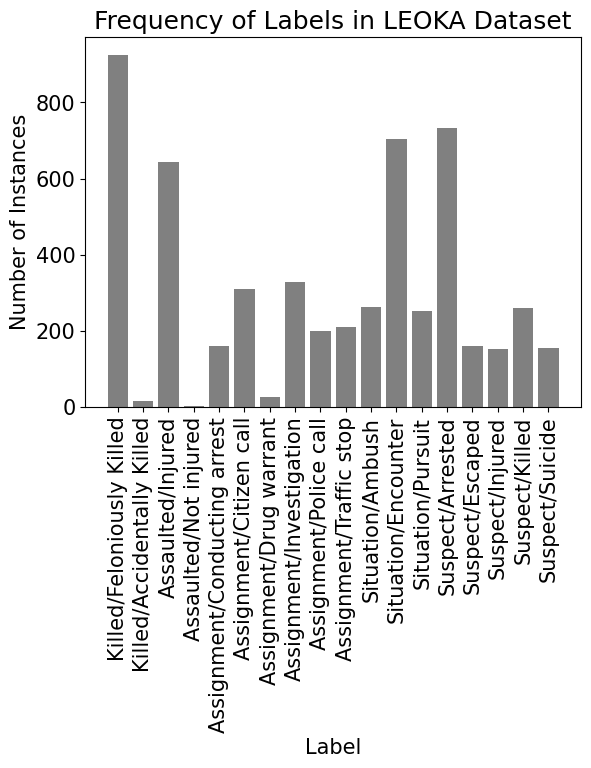

583 tasks for training.
349 for development.
234 for testing


In [2]:
# Data Analysis

# If True, data is already processed into tsv format with binarized label vector.
# If False, data is processed from a JSON from Label Studio and exported as a tsv with labels encoded.
# Note: For JSON format, it is assumed a train/dev/test split has not been done.
from_tsv = False

json_files =   [f"LEOKA_team_{i}.json" for i in range(1,12) if i != 5 and i != 9]
train_files = []
dev_files = []
test_files = []

def read_tsvs(tsvs):
    data = []
    for tsv in tsvs:
        with open(tsv, 'r') as file:
            tsv_reader = csv.reader(file, delimiter="\t", quotechar='"')
            for row in tsv_reader:
                text = row[0]
                labels = [int(i) for i in row[1:]]
                data.append([text, labels])
    return data

def write_tsv(texts, labels, file_name):
    with open(file_name, 'w') as file:
        tsv_writer = csv.writer(file, delimiter="\t", quotechar='"')
        for i in range(len(texts)):
            tsv_writer.writerow([texts[i]] + list(labels[i]))

def read_jsons(jsons):
    
    text_labels = []
    invalid_annotations = 0
    no_ground_truth = 0
    
    for json_file in jsons:
        with open(json_file, 'r') as json_file:

            tasks = json.load(json_file)

            total_tasks = len(tasks)
            
            labels = []
            for task in tasks:
                
                task_annotations = []
                
                for annotator in task["annotations"]:
                
                    if annotator["ground_truth"]:
                        for annotation in annotator["result"]:
                            if annotation["type"] == "taxonomy":
                                for label in annotation["value"]["taxonomy"]:
                                    try:
                                        task_annotations.append(f"{label[0]}/{label[1]}")
                                    except:
                                        invalid_annotations += 1
                                    
                if task_annotations:
                    labels.append([task["data"]["text"], task_annotations])
                else:
                    no_ground_truth += 1

        text_labels += labels
    print(f"Discarded {invalid_annotations} invalid labels.")
    print(f"{no_ground_truth} had no ground truth.")
    return text_labels

if from_tsv:
    train_texts, train_labels = zip(*read_tsvs(train_files))
    dev_texts, dev_labels = zip(*read_tsvs(train_files))
    test_texts, test_labels = zip(*read_tsvs(train_files))
else:
    texts, labels = zip(*read_jsons(json_files))

    valid_labels = ["Killed/Feloniously Killed", "Killed/Accidentally Killed", \
                    "Assaulted/Injured", "Assaulted/Not injured", \
                    "Assignment/Conducting arrest", "Assignment/Citizen call", "Assignment/Drug warrant", \
                        "Assignment/Investigation", "Assignment/Police call", "Assignment/Traffic stop", \
                    "Situation/Ambush", "Situation/Encounter", "Situation/Pursuit", \
                    "Suspect/Arrested", "Suspect/Escaped", "Suspect/Injured", "Suspect/Killed", "Suspect/Suicide"]

    mlb = MultiLabelBinarizer()
    mlb.fit([valid_labels])
    
    freq = {}
    for label in valid_labels:
        count = 0
        for task in labels:
            if label in task:
                count += 1
        freq[label] = count
        print(f"Instances of {label}: {count}")
        
    plt.rcParams.update({'font.size': 15})
    plt.bar(freq.keys(), freq.values(), color ='grey', 
        width = 0.8)
 
    plt.xlabel("Label")
    plt.ylabel("Number of Instances")
    plt.title("Frequency of Labels in LEOKA Dataset")
    plt.xticks(rotation=90)
    plt.show()

    labels = mlb.fit_transform(labels)

    train_texts, test_texts, train_labels, test_labels = train_test_split(texts,labels, random_state=4096,test_size=0.5, shuffle=True)
    dev_texts, test_texts, dev_labels, test_labels = train_test_split(test_texts,test_labels, random_state=4096,test_size=0.4, shuffle=True)

    write_tsv(train_texts, train_labels, "train.tsv")
    write_tsv(dev_texts, dev_labels, "dev.tsv")
    write_tsv(test_texts, test_labels, "test.tsv")

print(f"{len(train_texts)} tasks for training.\n{len(dev_texts)} for development.\n{len(test_texts)} for testing")

num_labels = len(valid_labels)